# Goal
- Find false innocents, could be through:
    - connections with many criminal nodes?
    - connection to a big criminal hub?

# Assumptions
- People connected to a crime as suspect or suspect/victim will be considered as being guilty of the crime they are connected to
- 

## Node categorisation
- criminal nodes: nodes that have been a suspect in a acrime at least once
- innocent nodes: nodes that have been only victims and/or witness

## Suspect role


# Work plan
Research question: is it possible to detect criminals that were not previously caught? - "criminal" disguised as "innocent"

- Does a strong link prediction between a criminal and an innocent suggests that the innocent might be a criminal in disguise?
- Compare the results from link prediction and community detection
- If they are in the same community? Is that an even stronger indication of a possible criminal?

# Imports

In [48]:
import pandas as pd
import statistics as stats
import numpy as np

import networkx as nx
from networkx.algorithms import bipartite

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
print('seaborn version', sns.__version__)
print('pandas version', pd.__version__)

seaborn version 0.11.2
pandas version 1.3.4


# Read data

In [50]:
al = '..//Data//out.moreno_crime_crime'
gender = '..//Data//ent.moreno_crime_crime.person.sex'
name = '..//Data//ent.moreno_crime_crime.person.name'
role = '..//Data//rel.moreno_crime_crime.person.role'

## Adjancency list as DataFrame

In [51]:
df_al = pd.read_csv(al, sep=" ", names=['person', 'crime'], index_col=False)
df_al['person'] = 'p' + df_al['person'].astype(str)
df_al['crime'] = 'c' + df_al['crime'].astype(str)
df_al.head(3)
df_al.shape

(1476, 2)

## Gender Dataframe

In [52]:
df_gender = pd.read_csv(gender, sep=" ", header=None, names=['gender'])
df_gender['person'] = 'p' + df_gender.index.astype(str)
df_gender.head(3)

,gender,person
0,1,p0
1,1,p1
2,1,p2


## Name DataFrame

In [53]:
df_name = pd.read_csv(name, sep=" ", header=None, names=['name'])
df_name['person'] = 'p' + df_name.index.astype(str)
df_name.head(3)

,name,person
0,AbelDennis,p0
1,AbramsChad,p1
2,AbramsDavid,p2


## Role Dataframe

In [54]:
df_role = pd.read_csv(role, sep=",", header=None, names=['role'])
# df_role.head(3)
df_role.shape

(1476, 1)

## Join adjancency list with role

In [55]:
df_al_roles = df_al.join(df_role)
df_al_roles.head(3)

,person,crime,role
0,p1,c1,Suspect
1,p1,c2,Victim
2,p1,c3,Victim


In [56]:
df_al_roles[df_al_roles['person'] == 'p815']

,person,crime,role
1434,p815,c511,Suspect
1435,p815,c513,Suspect
1436,p815,c529,Suspect
1437,p815,c546,Suspect
1438,p815,c308,Suspect
1439,p815,c489,Suspect
1440,p815,c473,Suspect
1441,p815,c525,Victim
1442,p815,c400,Suspect
1443,p815,c133,Suspect


In [57]:
# group bys gives us the same as degree distribution
# df_al_roles.groupby(by='person', dropna=False).count()
# df_al_roles.groupby(by=['crime', 'role'], dropna=False).count()

## Basic data stats

In [58]:
# the following are used to create the graph
people = df_al['person'].unique()
crimes = df_al['crime'].unique()
roles = df_role['role'].unique()

# print stats
print('Number of people:', len(people))
print('Number of crimes:', len(crimes))
print('Number of roles:', len(roles))
print('Number of edges:', len(df_al_roles))


Number of people: 829
Number of crimes: 551
Number of roles: 4
Number of edges: 1476


Breakdown of roles

In [59]:
df_role.value_counts()

role          
Suspect           682
Victim            558
Witness           195
Victim Suspect     41
dtype: int64

# Make graph

In [60]:
# G=nx.from_pandas_dataframe(df_al_roles, 0, 'b', ['weight', 'cost'])

In [61]:
# create networkx graph
G = nx.Graph()

# # add nodes
for i in range(len(people)):
    G.add_node(people[i], name=df_name['name'][i], gender=df_gender['gender'][i], bipartite=0)

for i in range(len(crimes)):
    G.add_node(crimes[i], bipartite=1)

# # add edges
for i in range(len(df_al)):
    G.add_edge(df_al_roles['person'][i], df_al_roles['crime'][i], role=df_al_roles['role'][i])

## Assign node status

In [62]:
# Code from Dee
# Initialize a dictionary based on people nodes to keep track of all roles per node
p_nodes = {el:[] for el in people}

# Add all the edge attributes to a dictionary of people nodes
for key,value in nx.get_edge_attributes(G, 'role').items():
    for part in key:
        if part in people:
            p_nodes[part].append(value)

# print(p_nodes['p1']) # List of all roles from p1

# Initialize a dictionary to keep track of who is a "criminal"
status = {el:[] for el in people}
    
# Loop through all roles per node, and deem them criminals if ever they have been a suspect
for key in p_nodes:
    if 'Suspect' in p_nodes[key]:
        status[key] = "criminal"
    elif 'Victim Suspect' in p_nodes[key]:
        status[key] = "criminal"
    else:
        status[key] = "innocent"

print(status['p336']) # Verify that p1 is deemed "criminal"

# Convert to pandas df
criminals_df = pd.DataFrame(status.items(), columns=['node', 'criminal_status'])

criminal


## Add node status

In [63]:
# loop through rows in the data frame and add the attribute of Criminal Status
for index, row in criminals_df.iterrows():
    #print(row['node'])
    G.nodes[row['node']]['criminal_status'] = row['criminal_status']

print(nx.get_node_attributes(G, 'criminal_status')['p1']) # check name of person 'p1' = 'Criminal'

criminal


In [64]:
# get top and bottom nodes for projection and plotting
people_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
crime_nodes = set(G) - people_nodes

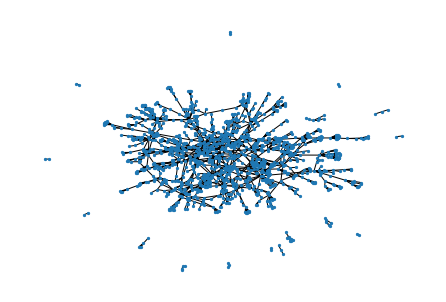

In [65]:
# plot only biggest component
# pos = nx.spring_layout(G)
# posB = nx.bipartite_layout(G, people_nodes)
G_draw = nx.draw_spring(G,node_size=5)

## Get degree of all nodes
Node degreee of **people** nodes if the number of crimes they were involved in.  
Node degree of **crime** nodes is the number of people involved in the crime.

In [66]:
# Creating dict with all node degrees to add as attribute
node_degrees = dict()

# Creating dict for each node type
people_degrees = dict()
crimes_degrees = dict()

# for loop to populate dicts above
for node in G.nodes:
    # print(G.edges(node, data=True))
    node_degrees[node] = G.degree(node)
    if node.startswith('p') == True:
        people_degrees[node] = G.degree(node)
    else:
        crimes_degrees[node] = G.degree(node)

In [67]:
df_gender = pd.read_csv(gender, sep=" ", header=None, names=['gender'])
df_gender['person'] = 'p' + df_gender.index.astype(str)
df_gender.head(3)

,gender,person
0,1,p0
1,1,p1
2,1,p2


In [68]:
# Add node degree as node attribute in graph G
nx.set_node_attributes(G, node_degrees, "node_degree")

# and check it worked
# nx.get_node_attributes(G, 'node_degree')

### Make a dataframe including all node attributes

In [69]:
# code from https://stackoverflow.com/a/50775962
# make pandas dataframe from graph with node attributes
df_G = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_G


,name,gender,bipartite,criminal_status,node_degree
p1,AbelDennis,1.0,0,criminal,4
p2,AbramsChad,1.0,0,criminal,22
p3,AbramsDavid,1.0,0,criminal,1
p4,AbramsDon,1.0,0,criminal,1
p5,AbramsRichard,1.0,0,innocent,1
...,...,...,...,...,...
c547,NaN,NaN,1,NaN,1
c548,NaN,NaN,1,NaN,1
c549,NaN,NaN,1,NaN,1
c550,NaN,NaN,1,NaN,1


In [70]:
df_G.loc[['p815']]

,name,gender,bipartite,criminal_status,node_degree
p815,WillisJenny,0.0,0,criminal,25


In [71]:
df_G['criminal_status'].value_counts()

criminal    442
innocent    387
Name: criminal_status, dtype: int64

# Projection on people

In [72]:
G_proj = bipartite.weighted_projected_graph(G, people_nodes, ratio=False)
list(G_proj.edges(data=True))[0:5]

[('p369', 'p144', {'weight': 1}),
 ('p369', 'p370', {'weight': 1}),
 ('p102', 'p680', {'weight': 1}),
 ('p102', 'p746', {'weight': 1}),
 ('p612', 'p659', {'weight': 1})]

In [73]:
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G_proj.number_of_nodes(), 
        G_proj.number_of_edges(), 
        nx.is_bipartite(G_proj),
        nx.is_connected(G_proj)
        )
    )

Num. of nodes: 829 
Num. of edges: 2253 
Is bipartite? False 
Is connected? False


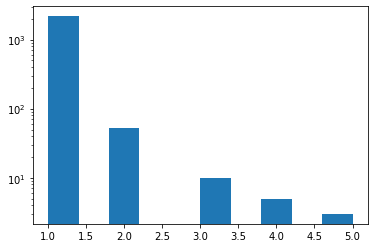

In [74]:
weights = list(nx.get_edge_attributes(G_proj, 'weight').values())

# plot weights
plt.hist(weights, bins = 10, log=True)
plt.show()

People of interest. Pairs that are connected by 5 crimes.

In [75]:
edge_w = list(G_proj.edges(data=True))

for i in edge_w:
    if i[2]['weight'] > 2:
        print(i)

('p396', 'p531', {'weight': 3})
('p815', 'p663', {'weight': 3})
('p303', 'p56', {'weight': 3})
('p37', 'p797', {'weight': 3})
('p592', 'p333', {'weight': 3})
('p659', 'p87', {'weight': 4})
('p17', 'p514', {'weight': 4})
('p54', 'p425', {'weight': 3})
('p128', 'p531', {'weight': 5})
('p425', 'p695', {'weight': 3})
('p425', 'p715', {'weight': 5})
('p425', 'p413', {'weight': 4})
('p767', 'p79', {'weight': 5})
('p67', 'p2', {'weight': 4})
('p715', 'p695', {'weight': 3})
('p413', 'p695', {'weight': 3})
('p533', 'p572', {'weight': 4})
('p344', 'p696', {'weight': 3})


In [76]:
# get adjacency matrix
A = nx.adjacency_matrix(G_proj, weight='weight')
A = A.toarray()

In [77]:
A[A > 2]

array([3, 3, 3, 3, 3, 3, 4, 4, 3, 5, 4, 4, 3, 5, 4, 3, 5, 4, 5, 3, 4, 3,
       4, 3, 3, 5, 4, 5, 3, 3, 3, 4, 3, 3, 3, 3], dtype=int32)

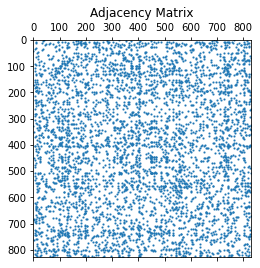

In [78]:
# plot adjacency matrix
plt.title('Adjacency Matrix')
# plt.imshow(A, cmap='Greys', markersize = 3)
# plt.show()
# plt.figure(figsize=(8,8))
plt.spy(A, markersize = 1)
plt.show()

<AxesSubplot:>

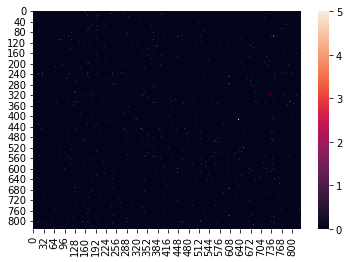

In [79]:
sns.heatmap(A)

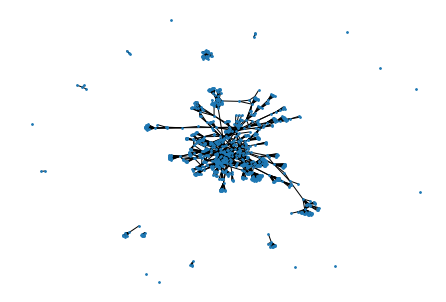

In [80]:
# plot graph visualisation
nx.draw_spring(G_proj, node_size=3)

# Link prediction on projected graph
from: https://www.networkatlas.eu/exercise.htm?c=20&e=1

In [81]:
linkpred_pa = list(nx.preferential_attachment(G_proj))

In [82]:
# Sort in decreasing score
linkpred_pa.sort(key = lambda tup: tup[2], reverse = True)

In [83]:
# Get the top 10
for edge_score in linkpred_pa[:10]:
   print(edge_score)

('p425', 'p2', 2448)
('p425', 'p356', 2244)
('p2', 'p56', 1584)
('p2', 'p695', 1584)
('p356', 'p56', 1452)
('p356', 'p695', 1452)
('p497', 'p2', 1440)
('p10', 'p425', 1428)
('p715', 'p2', 1392)
('p815', 'p425', 1377)


### Compare different link prediction methods
Code from: https://www.networkatlas.eu/exercise.htm?c=20&e=2

In [84]:
# Run the other link prediction methods implemented in networkx
linkpred_ja = list(nx.jaccard_coefficient(G_proj))
linkpred_aa = list(nx.adamic_adar_index(G_proj))
linkpred_ra = list(nx.resource_allocation_index(G_proj))

linkpred_ja.sort(key = lambda tup: tup[2], reverse = True)
linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
linkpred_ra.sort(key = lambda tup: tup[2], reverse = True)

In [85]:
# Print top predictions
print("PrefAtt\tJaccard\tAdamAd\tResAll")
for i in range(5):
   print("%s\t%s\t%s\t%s" % (linkpred_pa[i], linkpred_ja[i], linkpred_aa[i], linkpred_ra[i]))

PrefAtt	Jaccard	AdamAd	ResAll
('p425', 'p2', 2448)	('p102', 'p197', 1.0)	('p815', 'p336', 2.326022992233796)	('p815', 'p336', 0.7083333333333334)
('p425', 'p356', 2244)	('p383', 'p645', 1.0)	('p114', 'p365', 1.6072172535335318)	('p815', 'p301', 0.5)
('p2', 'p56', 1584)	('p383', 'p382', 1.0)	('p245', 'p680', 1.461880214172278)	('p269', 'p155', 0.5)
('p2', 'p695', 1584)	('p383', 'p555', 1.0)	('p466', 'p680', 1.461880214172278)	('p690', 'p132', 0.5)
('p356', 'p56', 1452)	('p548', 'p434', 1.0)	('p805', 'p746', 1.461880214172278)	('p237', 'p74', 0.5)


In [86]:
df_linkpred = pd.DataFrame(linkpred_ra, columns=['node1', 'node2', 'resource_allocation_score'])
df_linkpred['node1_status'] = df_linkpred['node1'].map(status)
df_linkpred['node2_status'] = df_linkpred['node2'].map(status)
# df_linkpred


In [138]:
df_linkpred_status = df_linkpred[df_linkpred['resource_allocation_score'] != 0]
df_linkpred_status.sort_values(by='resource_allocation_score', ascending=False)

,node1,node2,resource_allocation_score,node1_status,node2_status
0,p815,p336,0.708333,criminal,criminal
2,p269,p155,0.500000,criminal,innocent
3,p690,p132,0.500000,criminal,innocent
4,p237,p74,0.500000,innocent,criminal
5,p228,p514,0.500000,criminal,criminal
...,...,...,...,...,...
7833,p15,p776,0.019608,criminal,criminal
7832,p15,p774,0.019608,criminal,innocent
7831,p15,p128,0.019608,criminal,innocent
7830,p15,p53,0.019608,criminal,criminal


In [88]:
print(df_G.loc['p336'])
print(df_G.loc['p815'])

name                HallLiz
gender                  0.0
bipartite                 0
criminal_status    criminal
node_degree               9
Name: p336, dtype: object
name               WillisJenny
gender                     0.0
bipartite                    0
criminal_status       criminal
node_degree                 25
Name: p815, dtype: object


In [89]:
print(df_G.loc['p228'])
print(df_G.loc['p514'])

name               DukeAmelia
gender                    0.0
bipartite                   0
criminal_status      criminal
node_degree                 1
Name: p228, dtype: object
name               MccannEddie
gender                     1.0
bipartite                    0
criminal_status       criminal
node_degree                 11
Name: p514, dtype: object


In [90]:
print(df_G.loc['p301'])
print(df_G.loc['p815'])

name               GodfreyBrian
gender                      1.0
bipartite                     0
criminal_status        innocent
node_degree                   1
Name: p301, dtype: object
name               WillisJenny
gender                     0.0
bipartite                    0
criminal_status       criminal
node_degree                 25
Name: p815, dtype: object


In [91]:
print(df_G.loc['p797'])
print(df_G.loc['p293'])

name               WethersMorrie
gender                       1.0
bipartite                      0
criminal_status         criminal
node_degree                    7
Name: p797, dtype: object
name               GillisJohnson
gender                       1.0
bipartite                      0
criminal_status         innocent
node_degree                    1
Name: p293, dtype: object


In [92]:
print(df_G.loc['p155'])
print(df_G.loc['p269'])

name               ChandlerSusie
gender                       0.0
bipartite                      0
criminal_status         innocent
node_degree                    5
Name: p155, dtype: object
name               ForesterCarol
gender                       0.0
bipartite                      0
criminal_status         criminal
node_degree                    2
Name: p269, dtype: object


In [93]:
df_linkpred[df_linkpred['resource_allocation_score'] >= .5]

,node1,node2,resource_allocation_score,node1_status,node2_status
0,p815,p336,0.708333,criminal,criminal
1,p815,p301,0.500000,criminal,innocent
2,p269,p155,0.500000,criminal,innocent
3,p690,p132,0.500000,criminal,innocent
4,p237,p74,0.500000,innocent,criminal
5,p228,p514,0.500000,criminal,criminal
6,p214,p215,0.500000,criminal,criminal
7,p293,p797,0.500000,innocent,criminal
8,p691,p695,0.500000,criminal,criminal


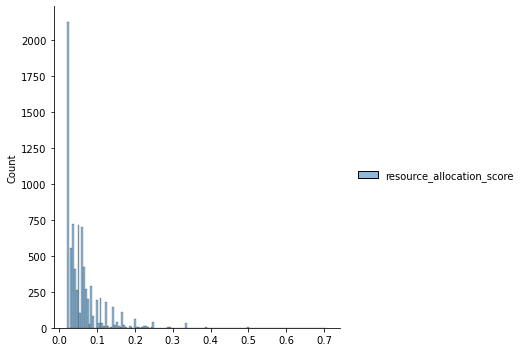

In [94]:
sns.displot(df_linkpred[df_linkpred['resource_allocation_score'] > 0]);

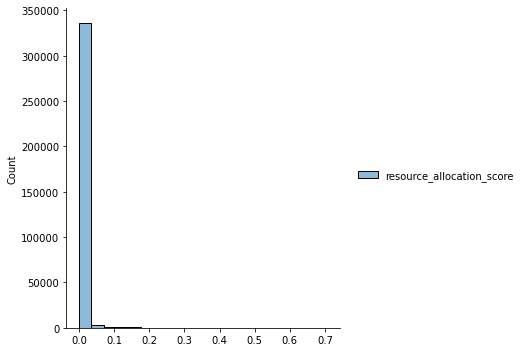

In [95]:
sns.displot(df_linkpred)

In [96]:
df_G.iloc[410,:]

name               JohnsonDennis
gender                       1.0
bipartite                      0
criminal_status         criminal
node_degree                    3
Name: p411, dtype: object

In [97]:
df_G.iloc[282,:]

name               GellarLindsay
gender                       0.0
bipartite                      0
criminal_status         criminal
node_degree                    2
Name: p283, dtype: object

## Link prediction experiment
from: https://www.networkatlas.eu/exercise.htm?c=22&e=1

Divide this network into train and test sets using a ten-fold cross validation scheme. Draw its confusion matrix after applying a jaccard link prediction to it. Use 0.5 as you cutoff score: scores equal to or higher than 0.5 are predicted to be an edge, anything lower is predicted to be a non-edge.

In [98]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [99]:
# Load the data as a pandas dataframe
# df1 = pd.read_csv("data.txt", sep = " ", header = None, names = ("src", "trg"))
# df1["target"] = 1
# df1

In [100]:
df = nx.to_pandas_edgelist(G_proj)
df["target2"] = 1
df

,source,target,weight,target2
0,p369,p144,1,1
1,p369,p370,1,1
2,p102,p680,1,1
3,p102,p746,1,1
4,p612,p659,1,1
...,...,...,...,...
2248,p806,p39,1,1
2249,p793,p731,1,1
2250,p665,p305,1,1
2251,p795,p606,1,1


In [101]:
# Let's make a ten fold split
kf = KFold(n_splits = 10, shuffle = True)

In [102]:
# Each fold generates the graph we need for training link prediction and the dataframe
# we use to test it.
y_true = []
y_pred = []
for train_index, test_index in kf.split(df):
   # Generate the train graph
   G_train = nx.from_pandas_edgelist(df.loc[train_index], source = "source", target = "target")
   # Make a dataframe with the results of the jaccard prediction
   score = pd.DataFrame(list(nx.jaccard_coefficient(G_train)), columns = ("source", "target", "score"))
   # Merge with the test set
   df_test = df.loc[test_index].merge(score, on = ["source", "target"], how = "outer").fillna(0)
   # Threshold the results with the cutoff
   df_test["prediction"] = df_test["score"] >= 0.5
   y_true += list(df_test["target2"])
   y_pred += list(df_test["prediction"])

In [103]:
# Make the confusion matrix, which has this shape:
# [[ TN, FN ],
#  [ FP, TP ]]
confusion_matrix(y_true, y_pred)

array([[3214833,    2196],
       [   1138,    1115]], dtype=int64)

### Compare the methods
from: https://www.networkatlas.eu/exercise.htm?c=22&e=2

In [104]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

In [136]:
df.loc[train_index]

,source,target,weight,target2
0,p369,p144,1,1
1,p369,p370,1,1
2,p102,p680,1,1
3,p102,p746,1,1
4,p612,p659,1,1
...,...,...,...,...
2247,p689,p16,1,1
2248,p806,p39,1,1
2249,p793,p731,1,1
2250,p665,p305,1,1


In [105]:
pas = pd.DataFrame()
jas = pd.DataFrame()
aas = pd.DataFrame()
ras = pd.DataFrame()

for train_index, test_index in kf.split(df):
   G = nx.from_pandas_edgelist(df.loc[train_index], source = "source", target = "target")
   pa = pd.DataFrame(list(nx.preferential_attachment(G)), columns = ("source", "target", "score"))
   ja = pd.DataFrame(list(nx.jaccard_coefficient(G)), columns = ("source", "target", "score"))
   aa = pd.DataFrame(list(nx.adamic_adar_index(G)), columns = ("source", "target", "score"))
   ra = pd.DataFrame(list(nx.resource_allocation_index(G)), columns = ("source", "target", "score"))
   # Now we keep all scores, because we want to plot the full ROC curve rather than a simple confusion matrix
   pas = pd.concat([pas, df.loc[test_index].merge(pa, on = ["source", "target"], how = "outer").fillna(0)])
   jas = pd.concat([jas, df.loc[test_index].merge(ja, on = ["source", "target"], how = "outer").fillna(0)])
   aas = pd.concat([aas, df.loc[test_index].merge(aa, on = ["source", "target"], how = "outer").fillna(0)])
   ras = pd.concat([ras, df.loc[test_index].merge(ra, on = ["source", "target"], how = "outer").fillna(0)])

In [131]:
# to look at specific people
# ras[ras['source'] == 'p425']

In [139]:
mod = ras
mod[mod['score'] > 0].sort_values(by='score', ascending=False).head(10)

,source,target,weight,target2,score,prediction
164,p425,p695,3.0,1.0,1.679614,True
57,p37,p797,3.0,1.0,1.664286,True
103,p418,p356,2.0,1.0,1.577381,True
17,p97,p497,2.0,1.0,1.480829,True
12,p97,p73,2.0,1.0,1.464104,True
165,p425,p715,5.0,1.0,1.420052,True
50,p326,p37,2.0,1.0,1.416667,True
31,p146,p145,2.0,1.0,1.383333,True
47,p811,p425,2.0,1.0,1.350105,True
198,p356,p731,2.0,1.0,1.333333,True


In [109]:
# And now we draw the ROCs
fpr_pa, tpr_pa, thresholds = roc_curve(pas["target2"], pas["score"])
fpr_ja, tpr_ja, thresholds = roc_curve(jas["target2"], jas["score"])
fpr_aa, tpr_aa, thresholds = roc_curve(aas["target2"], aas["score"])
fpr_ra, tpr_ra, thresholds = roc_curve(ras["target2"], ras["score"])

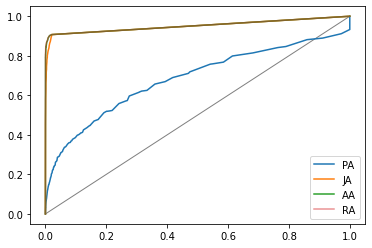

In [111]:
# First we plot the random classifier performance
plt.plot([0, 1], [0, 1], color = 'gray', lw = 1)
# Then the actual classifiers
plt.plot(fpr_pa, tpr_pa, label = "PA")
plt.plot(fpr_ja, tpr_ja, label = "JA")
plt.plot(fpr_aa, tpr_aa, label = "AA")
plt.plot(fpr_ra, tpr_ra, label = "RA", alpha=.5)
plt.legend(loc = "lower right")
plt.show()

In [112]:
# Let's print the AUCs
print("PA's AUC: %1.4f" % auc(fpr_pa, tpr_pa))
print("JA's AUC: %1.4f" % auc(fpr_ja, tpr_ja))
print("AA's AUC: %1.4f" % auc(fpr_aa, tpr_aa))
print("RA's AUC: %1.4f" % auc(fpr_ra, tpr_ra))

# Resource allocation works best!

PA's AUC: 0.6824
JA's AUC: 0.9505
AA's AUC: 0.9521
RA's AUC: 0.9522


### Calculate precision, recall, and F1-score for the four link predictors
from: https://www.networkatlas.eu/exercise.htm?c=22&e=3

In [113]:
from sklearn.metrics import precision_recall_fscore_support

In [123]:
# Get only top 10% of scores as actual predictions
pas["prediction"] = pas["score"].rank(pct = True) >= 0.9
jas["prediction"] = jas["score"].rank(pct = True) >= 0.9
aas["prediction"] = aas["score"].rank(pct = True) >= 0.9
ras["prediction"] = ras["score"].rank(pct = True) >= 0.9

In [124]:
# And now we calculate our quality measures
prec_pa, recall_pa, f1_pa, _ = precision_recall_fscore_support(pas["target2"], pas["prediction"], average = "binary")
prec_ja, recall_ja, f1_ja, _ = precision_recall_fscore_support(jas["target2"], jas["prediction"], average = "binary")
prec_aa, recall_aa, f1_aa, _ = precision_recall_fscore_support(aas["target2"], aas["prediction"], average = "binary")
prec_ra, recall_ra, f1_ra, _ = precision_recall_fscore_support(ras["target2"], ras["prediction"], average = "binary")

In [125]:

# Let's figure out who performs best:
print("PA's precision = %1.4f, recall = %1.4f, F1 = %1.4f" % (prec_pa, recall_pa, f1_pa))
print("JA's precision = %1.4f, recall = %1.4f, F1 = %1.4f" % (prec_ja, recall_ja, f1_ja))
print("AA's precision = %1.4f, recall = %1.4f, F1 = %1.4f" % (prec_aa, recall_aa, f1_aa))
print("RA's precision = %1.4f, recall = %1.4f, F1 = %1.4f" % (prec_ra, recall_ra, f1_ra))

# Resource allocation is both the most precise and complete, and thus has also the highest F1 score

PA's precision = 0.0027, recall = 0.3879, F1 = 0.0054
JA's precision = 0.0293, recall = 0.9072, F1 = 0.0568
AA's precision = 0.0293, recall = 0.9072, F1 = 0.0568
RA's precision = 0.0293, recall = 0.9072, F1 = 0.0568


### Draw the precision-recall curves of the four link predictors
from: https://www.networkatlas.eu/exercise.htm?c=22&e=4

In [117]:
from sklearn.metrics import precision_recall_curve, auc

In [118]:
# Let's draw the precision-recall curve! Not much different from ROC
pr_pa, rec_pa, thresholds = precision_recall_curve(pas["target2"], pas["score"])
pr_ja, rec_ja, thresholds = precision_recall_curve(jas["target2"], jas["score"])
pr_aa, rec_aa, thresholds = precision_recall_curve(aas["target2"], aas["score"])
pr_ra, rec_ra, thresholds = precision_recall_curve(ras["target2"], ras["score"])

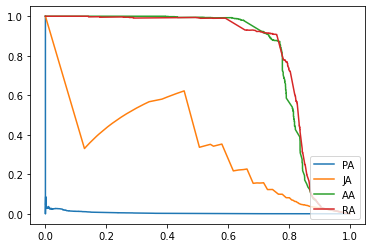

In [119]:
# Remember that here the random classifier is not the 45 degree line, so let's just plot the curves
# I use a logarithmic x axis for convenience.
plt.plot(rec_pa, pr_pa, label = "PA")
plt.plot(rec_ja, pr_ja, label = "JA")
plt.plot(rec_aa, pr_aa, label = "AA")
plt.plot(rec_ra, pr_ra, label = "RA")
plt.legend(loc = "lower right")
plt.show()

In [120]:
# Let's print the AUCs
print("PA's AUC: %1.4f" % auc(rec_pa, pr_pa))
print("JA's AUC: %1.4f" % auc(rec_ja, pr_ja))
print("AA's AUC: %1.4f" % auc(rec_aa, pr_aa))
print("RA's AUC: %1.4f" % auc(rec_ra, pr_ra))

# We already knew that resource allocation works best.

PA's AUC: 0.0049
JA's AUC: 0.3478
AA's AUC: 0.8073
RA's AUC: 0.8130
